In [3]:
import geopandas as gpd
import pandas as pd

gdf_malla_peninsula = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos IEET\Mallas Península\Malla10km_p.shp")
gdf_malla_canarias = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos IEET\Mallas Canarias\Malla10km_c.shp")

ccaa_peninsula = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos Rutas\Mallas\Mallas_CCAA\Malla_Peninsula\se89_10_admin_ccaa_a_x.shp")
ccaa_canarias = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos Rutas\Mallas\Mallas_CCAA\Malla_Canarias\se89_10_admin_ccaa_a_y.shp")

prov_peninsula = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos Rutas\Mallas\Mallas_Prov\Malla_Peninsula\se89_10_admin_prov_a_x.shp")
prov_canarias = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos Rutas\Mallas\Mallas_Prov\Malla_Canarias\se89_10_admin_prov_a_y.shp")


## Crear una correspondencia de las cuadriculas con CCAA y provincias

In [13]:
# Convertir todo a las mismas coordenadas, usando EPSG=4326
ccaa_peninsula = ccaa_peninsula.to_crs(epsg=4326)
ccaa_canarias = ccaa_canarias.to_crs(epsg=4326)
gdf_malla_canarias = gdf_malla_canarias.to_crs(epsg=4326)
gdf_malla_peninsula  = gdf_malla_peninsula.to_crs(epsg=4326)
prov_peninsula = prov_peninsula.to_crs(epsg=4326)
prov_canarias = prov_canarias.to_crs(epsg=4326)

print("CRS malla_peninsula:", gdf_malla_peninsula.crs)
print("CRS ccaa_peninsula:", ccaa_peninsula.crs)
print("CRS prov_peninsula:", prov_peninsula.crs)
print("CRS malla_canarias:", gdf_malla_canarias.crs)
print("CRS ccaa_canarias:", ccaa_canarias.crs)
print("CRS prov_canarias:", prov_canarias.crs)


CRS malla_peninsula: EPSG:4326
CRS ccaa_peninsula: EPSG:4326
CRS prov_peninsula: EPSG:4326
CRS malla_canarias: EPSG:4326
CRS ccaa_canarias: EPSG:4326
CRS prov_canarias: EPSG:4326


In [45]:
# Hacer la intersección espacial
malla_ccaa_peninsula = gpd.sjoin(gdf_malla_peninsula, ccaa_peninsula, how="left", predicate="intersects")
malla_ccaa_canarias = gpd.sjoin(gdf_malla_canarias, ccaa_canarias, how="left", predicate="intersects")
malla_prov_peninsula = gpd.sjoin(gdf_malla_peninsula, prov_peninsula, how="left", predicate="intersects")
malla_prov_canarias = gpd.sjoin(gdf_malla_canarias, prov_canarias, how="left", predicate="intersects")


# Renombrar las columnas para evitar confusión
malla_ccaa_peninsula.rename(columns={"rotulo": "CCAA"}, inplace=True)
malla_ccaa_canarias.rename(columns={"rotulo": "CCAA"}, inplace=True)
malla_prov_peninsula.rename(columns={"rotulo": "Provincia"}, inplace=True)
malla_prov_canarias.rename(columns={"rotulo": "Provincia"}, inplace=True)



Cuadrículas de Península sin coincidencia: 5998
Cuadrículas de Canarias sin coincidencia: 5031
<class 'geopandas.geodataframe.GeoDataFrame'>


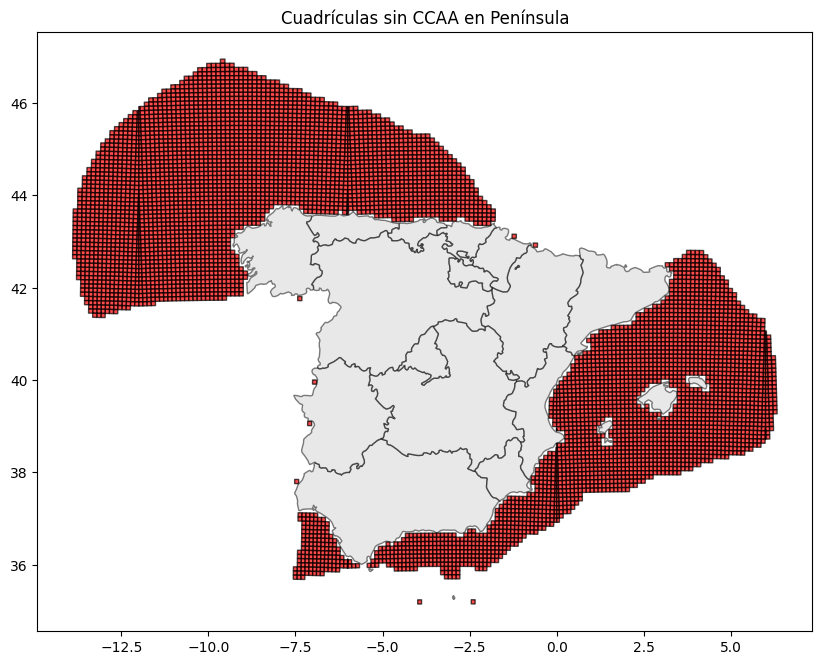

In [36]:
import matplotlib.pyplot as plt

malla_peninsula_faltantes = malla_ccaa_peninsula[malla_ccaa_peninsula["CCAA"].isna()]
print("Cuadrículas de Península sin coincidencia:", len(malla_peninsula_faltantes))

malla_canarias_faltantes = malla_ccaa_canarias[malla_ccaa_canarias["CCAA"].isna()]
print("Cuadrículas de Canarias sin coincidencia:", len(malla_canarias_faltantes))

print(type(malla_peninsula_faltantes))

fig, ax = plt.subplots(figsize=(10, 8))

# Dibujar el mapa de CCAA en gris
ccaa_peninsula.plot(ax=ax, color="lightgray", edgecolor="black", alpha=0.5)

# Asegurar que las cuadrículas sin coincidencia son un GeoDataFrame
if not malla_peninsula_faltantes.empty:
    malla_peninsula_faltantes.plot(ax=ax, color="red", edgecolor="black", alpha=0.7)

plt.title("Cuadrículas sin CCAA en Península")
plt.show()

In [46]:
malla_prov_peninsula = (malla_prov_peninsula.groupby("CUADRICULA")["Provincia"]
                            .apply(lambda x: ", ".join(sorted(set(x.dropna()))))
                            .reset_index())

malla_prov_canarias = (malla_prov_canarias.groupby("CUADRICULA")["Provincia"]
                           .apply(lambda x: ", ".join(sorted(set(x.dropna()))))
                           .reset_index())

# Agrupar por CUADRICULA y combinar todas las CCAA en una misma celda
malla_ccaa_peninsula = (malla_ccaa_peninsula.groupby("CUADRICULA")["CCAA"]
                            .apply(lambda x: ", ".join(sorted(set(x.dropna()))))
                            .reset_index())


malla_ccaa_canarias = (malla_ccaa_canarias.groupby("CUADRICULA")["CCAA"]
                           .apply(lambda x: ", ".join(sorted(set(x.dropna()))))
                           .reset_index())

In [47]:
# Unir las cuadrículas con sus comunidades autónomas y provincias
malla_ccaa_prov_peninsula = pd.merge(malla_ccaa_peninsula, malla_prov_peninsula, on="CUADRICULA", how="left")
malla_ccaa_prov_canarias = pd.merge(malla_ccaa_canarias, malla_prov_canarias, on="CUADRICULA", how="left")

# Combinar los GeoDataFrame de Península y Canarias
malla_ccaa_prov_total = pd.concat([malla_ccaa_prov_peninsula, malla_ccaa_prov_canarias], ignore_index=True)[["CUADRICULA", "CCAA", "Provincia"]]

In [31]:

# Unir Comunidad Autónoma y Provincia por "CUADRICULA"
malla_peninsula = pd.merge(malla_ccaa_peninsula, malla_prov_peninsula, on="CUADRICULA", how="left")
malla_canarias = pd.merge(malla_ccaa_canarias, malla_prov_canarias, on="CUADRICULA", how="left")

# Unir Península y Canarias en un solo DataFrame
malla_total = pd.concat([malla_peninsula, malla_canarias], ignore_index=True)[["CUADRICULA", "CCAA", "Provincia"]]

In [48]:
# Guardar el resultado en un CSV
malla_ccaa_prov_total.to_csv(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos Rutas/mallas_con_ccaa_y_prov.csv", index=False)

print("Proceso completado. Se ha generado 'mallas_con_ccaas_y_prov.csv'")

Proceso completado. Se ha generado 'mallas_con_ccaas_y_prov.csv'


## Asignar rutas a CCAA y provincias

In [73]:
# Cargar el archivo CSV de rutas
df_rutas = pd.read_csv(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos Rutas\archivo_rutas_con_cuadricula.csv")

# Renombrar df_rutas original para evitar perder la información
df_rutas_original = df_rutas.copy()


In [74]:
# Separar los códigos de cuadrícula en filas individuales
df_rutas = df_rutas_original.set_index('ID_Ruta').CUADRICULA.str.split(',', expand=True).stack().reset_index(level=1, drop=True)
df_rutas = df_rutas.reset_index().rename(columns={0: 'CUADRICULA'})

# Renombrar las columnas 'CCAA' y 'Provincia' antes de hacer el merge
malla_ccaa_prov_total = malla_ccaa_prov_total.rename(columns={'CCAA': 'CCAA_1', 'Provincia': 'Provincia_1'})

# Unir el DataFrame de rutas con el DataFrame de cuadrículas con CCAA y Provincias
df_rutas_con_info = pd.merge(df_rutas, malla_ccaa_prov_total[['CUADRICULA', 'CCAA_1', 'Provincia_1']], on='CUADRICULA', how='left')

In [75]:
# Agrupar por ID_Ruta y combinar las CCAA y Provincias en listas
df_rutas_con_info_agrupadas = df_rutas_con_info.groupby('ID_Ruta').agg({
    'CCAA_1': lambda x: ", ".join(sorted(set(x.dropna()))),  # Lista de CCAA sin duplicados
    'Provincia_1': lambda x: ", ".join(sorted(set(x.dropna()))),  # Lista de Provincias sin duplicados
}).reset_index()


In [77]:
# Unir las rutas originales con las columnas de CCAA y Provincia agrupadas
df_rutas_final = pd.merge(df_rutas_original, df_rutas_con_info_agrupadas[['ID_Ruta', 'CCAA_1', 'Provincia_1']], on='ID_Ruta', how='left')

df_rutas_final.to_csv(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos Rutas/archivo_rutas_con_cuadricula_y_ccaa.csv", index=False, encoding="utf-8-sig")


## Repartir en archivo por cada comunidad

In [78]:
# Cargar el archivo CSV de rutas
df_rutas = pd.read_csv(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos Rutas\archivo_rutas_con_cuadricula_y_ccaa.csv")


In [82]:
# Crear un archivo para las rutas con varias comunidades
df_varias_comunidades = df_rutas_final[df_rutas_final['CCAA_1'].str.contains(',')]

# Guardar el archivo con rutas que contienen varias comunidades
df_varias_comunidades.to_csv(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos Rutas/Rutas_Limpias/rutas_VariasComunidades.csv", index=False, encoding="utf-8-sig")


In [85]:
df_rutas_solo_una_comunidad = df_rutas_final[~df_rutas_final['CCAA_1'].str.contains(',')]

# Obtener todas las comunidades únicas (solo aquellas con una comunidad por fila)
comunidades = df_rutas_solo_una_comunidad['CCAA_1'].dropna().unique()

import os

# Definir la ruta de la carpeta
ruta_directorio = r"C:/Users/maria.b.calvo/Documents/Personal/Hackathon GenAI/hackathon-repo/Hackathon-PNAV/Datos/Datos Rutas/Rutas_Limpias"

# Iterar sobre cada comunidad y guardar un archivo solo con las rutas correspondientes a esa comunidad
for comunidad in comunidades:
    df_comunidad = df_rutas_solo_una_comunidad[df_rutas_solo_una_comunidad['CCAA_1'] == comunidad]
    
    # Generar el nombre del archivo
    nombre_archivo = f"rutas_{comunidad.strip().replace(' ', '_').replace(',', '').replace('/', '_')}.csv"
    
    print(f"Guardando archivo: {nombre_archivo}")
    
    # Guardar el archivo
    df_comunidad.to_csv(os.path.join(ruta_directorio, nombre_archivo), index=False, encoding="utf-8-sig")


Guardando archivo: rutas_Canarias.csv
Guardando archivo: rutas_Galicia.csv
Guardando archivo: rutas_Castilla_y_León.csv
Guardando archivo: rutas_Andalucía.csv
Guardando archivo: rutas_Principado_de_Asturias.csv
Guardando archivo: rutas_Extremadura.csv
Guardando archivo: rutas_Aragón.csv
Guardando archivo: rutas_Castilla-La_Mancha.csv
Guardando archivo: rutas_Comunidad_Foral_de_Navarra.csv
Guardando archivo: rutas_Cantabria.csv
Guardando archivo: rutas_Comunitat_Valenciana.csv
Guardando archivo: rutas_País_Vasco_Euskadi.csv
Guardando archivo: rutas_La_Rioja.csv
Guardando archivo: rutas_Región_de_Murcia.csv
Guardando archivo: rutas_Comunidad_de_Madrid.csv
Guardando archivo: rutas_Cataluña_Catalunya.csv
Guardando archivo: rutas_Illes_Balears.csv
Guardando archivo: rutas_.csv
Guardando archivo: rutas_Ciudad_de_Ceuta.csv


In [86]:
import pandas as pd
import os

# Ruta base donde están los archivos de rutas por comunidad
ruta_base = r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\Datos\Datos Rutas/Rutas_Limpias"

# Cargar el archivo VariasComunidades.csv
archivo_varias = os.path.join(ruta_base, "rutas_VariasComunidades.csv")
df_varias = pd.read_csv(archivo_varias)

# Iterar sobre cada fila del DataFrame
for index, row in df_varias.iterrows():
    comunidades = row['CCAA_1'].split(', ')  # Dividir en lista de comunidades

    for comunidad in comunidades:
        # Construir el nombre del archivo de destino
        nombre_archivo = f"rutas_{comunidad.strip().replace(' ', '_').replace(',', '').replace('/', '_')}.csv"
        ruta_archivo = os.path.join(ruta_base, nombre_archivo)

        # Intentar leer y agregar la fila
        if os.path.exists(ruta_archivo):
            df_comunidad = pd.read_csv(ruta_archivo)  # Leer el archivo de la comunidad
            df_comunidad = pd.concat([df_comunidad, pd.DataFrame([row])], ignore_index=True)  # Agregar la fila
            df_comunidad.to_csv(ruta_archivo, index=False, encoding="utf-8-sig")  # Guardar
        else:
            print(f"⚠️ ERROR: No se encontró el archivo {nombre_archivo}. Revisa manualmente.")


## Procesar rutas que no fueron asignadas (Islas Cíes)

In [87]:
import pandas as pd

# Cargar el archivo rutas_.csv
ruta_original = "C:/Users/maria.b.calvo/Documents/Personal/Hackathon GenAI/hackathon-repo/Hackathon-PNAV/Datos/Datos Rutas/Rutas_Limpias/rutas_.csv"
df_rutas = pd.read_csv(ruta_original)

# Modificar las columnas
df_rutas["CCAA_1"] = "Galicia"
df_rutas["Provincia_1"] = "Pontevedra"

# Cargar el archivo rutas_Galicia.csv
ruta_galicia = "C:/Users/maria.b.calvo/Documents/Personal/Hackathon GenAI/hackathon-repo/Hackathon-PNAV/Datos/Datos Rutas/Rutas_Limpias/rutas_Galicia.csv"

df_galicia = pd.read_csv(ruta_galicia)

# Concatenar los datos
df_actualizado = pd.concat([df_galicia, df_rutas], ignore_index=True)

# Guardar el archivo actualizado
df_actualizado.to_csv(ruta_galicia, index=False, encoding="utf-8-sig")

print("Archivo rutas_Galicia.csv actualizado correctamente.")


Archivo rutas_Galicia.csv actualizado correctamente.
